In [1]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from IPython.display import HTML

from astropy import units as u

from visualize_foreground import *

R_sun = 6.957e10
%matplotlib inline

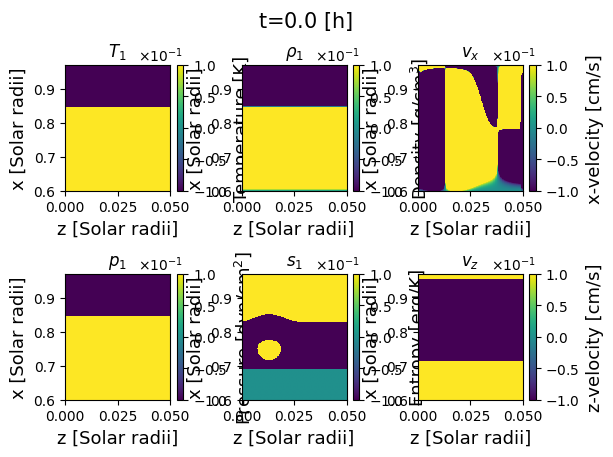

In [106]:
vf_rk2_upw1 = Visualize_Foreground("../data/test_pert_rk2_upw1/")
vf_rk2_upw1.plot_all(plt.figure(), 6)

In [214]:
variables, info = read_fg("../data/rk2_upw2_pertubation/snap100.h5")
print((1/(np.max(np.abs(variables['vx']))/info['dx'])*u.s).to('h'))

#plt.imshow(variables['vz'], aspect=1/5, origin='lower')
#plt.colorbar()

493.8602276598029 h


In [68]:
t = []
vx_max = []

for i in range(600):
    variables, info = read_fg("../data/vz_ten_copy/snap{}.h5".format(i))
    vx_max.append(np.max(np.abs(variables['vz'])))
    t.append(info['t'])


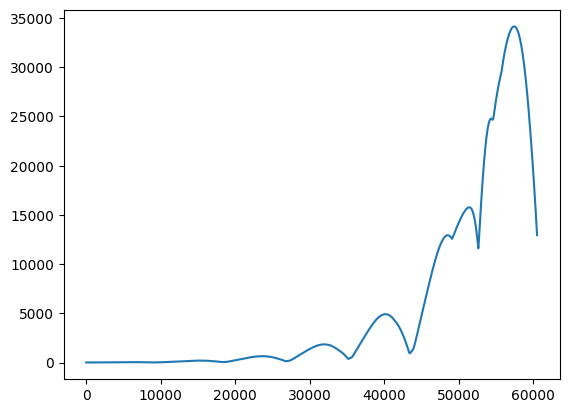

In [69]:
plt.plot(t, vx_max)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/matplotlib/image.py:492: RuntimeWarning: overflow encountered in divide
  vrange /= ((a_max - a_min) / frac)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/colors.py:1355: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


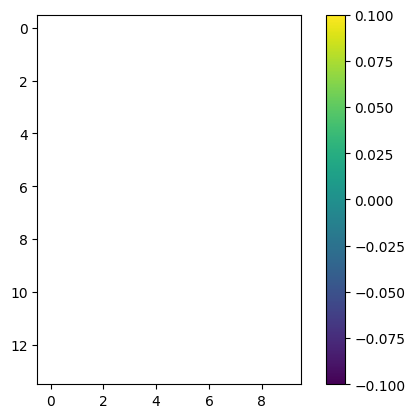

In [10]:
plt.imshow(variables['T1'])
plt.colorbar()
plt.show()

In [31]:
r/R_sun

array([5.17777778e-01, 5.58888889e-01, 6.00000000e-01, 6.41111111e-01,
       6.82222222e-01, 7.23333333e-01, 7.64444444e-01, 8.05555556e-01,
       8.46666667e-01, 8.87777778e-01, 5.13367571e-05, 1.01111111e+00,
       1.01111111e+00, 1.09333333e+00])

In [36]:
r/R_sun

array([5.17777778e-01, 5.58888889e-01, 6.00000000e-01, 6.41111111e-01,
       6.82222222e-01, 7.23333333e-01, 7.64444444e-01, 8.05555556e-01,
       8.46666667e-01, 8.87777778e-01, 5.13367571e-05, 1.01111111e+00,
       1.01111111e+00, 1.09333333e+00])

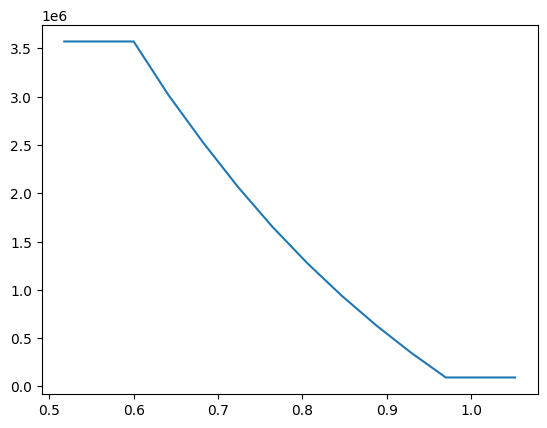

In [37]:

with h5py.File('../data/save_test/background.h5', 'r') as f:
    r = f['/variables/r'][:]
    T0 = f['/variables/T0'][:]
plt.plot(r/R_sun, T0)
plt.show()

In [15]:
!ls -l ../data/save_test/snap0.h5

In [58]:
variables, info = read_fg("../data/save_test/snap12.h5")

variables['vz']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

/var/folders/k6/k6jkpmqs13l4qhz_xy4wzlmw0000gn/T/ipykernel_2286/967915779.py:7: RuntimeWarning: divide by zero encountered in divide
  H = - dz / dp * bg_variables['p0'][:-1]


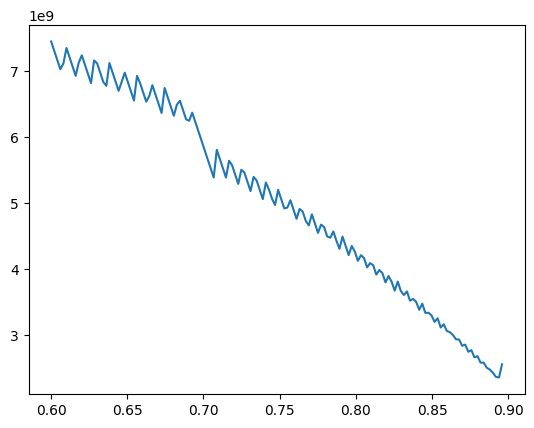

In [267]:
#H = - dz / dlnp = - dz p /dp

bg_variables, info_bg = read_bg("../data/rk2_upw2_pertubation_no_max//background.h5")

dz = (bg_variables['r'] - np.roll(bg_variables['r'], -1))[:-1]
dp = (bg_variables['p0'] - np.roll(bg_variables['p0'], -1))[:-1]
H = - dz / dp * bg_variables['p0'][:-1]

plt.plot(bg_variables['r'][:-1]/R_sun, H)

In [271]:
info['dx']/1e9

0.0891923076923077

In [280]:
info['dz']/1e9 / 2

0.07003691275167787

In [257]:
info['dx'], info['dz'], info['nx'], info['nz']

(array(89192307.6923077),
 array(1.40073826e+08),
 array(40, dtype=int32),
 array(150, dtype=int32))

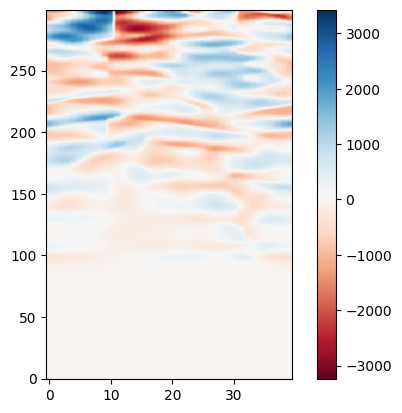

In [292]:
variables, info = read_fg('../data/rk2_upw2_pertubation_no_max_higher_z_res/snap255.h5')
nz_ghost = info['nz_ghost']
plt.imshow(variables['vx'][nz_ghost:-nz_ghost], origin='lower', aspect=1/5, cmap='RdBu')
plt.colorbar()
plt.show()

In [216]:
def print_attrs(name, obj):
    """Print attributes of the HDF5 object."""
    print(name)
    for key, val in obj.attrs.items():
        print(f"  ATTRIBUTE {key}: {val}")

def explore_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        # Print the attributes of the root group
        print_attrs('/', f)

        # Using the visititems method to traverse the file's structure
        f.visititems(print_attrs)

file_path = '../data/rk2_upw2_pertubation_no_max/snap132.h5'
explore_hdf5(file_path)

/
  ATTRIBUTE header: [b'This is the root header']
grid_info
  ATTRIBUTE header: [b'This is the grid data header']
grid_info/dx
  ATTRIBUTE unit: [b'cm']
grid_info/dz
  ATTRIBUTE unit: [b'cm']
grid_info/nx
  ATTRIBUTE unit: [b'Grid points in x']
grid_info/nz
  ATTRIBUTE unit: [b'Grid points in z']
grid_info/nz_full
  ATTRIBUTE unit: [b'Full grid points in z']
grid_info/nz_ghost
  ATTRIBUTE unit: [b'Ghost points in z']
grid_info/t
  ATTRIBUTE unit: [b's']
grid_info/x0
  ATTRIBUTE unit: [b'cm']
grid_info/x1
  ATTRIBUTE unit: [b'cm']
grid_info/z0
  ATTRIBUTE unit: [b'cm']
grid_info/z1
  ATTRIBUTE unit: [b'cm']
variables
  ATTRIBUTE header: [b'This is the variables header']
variables/T1
  ATTRIBUTE unit: [b'K']
variables/p1
  ATTRIBUTE unit: [b'dyn/cm^2']
variables/rho1
  ATTRIBUTE unit: [b'g/cm^3']
variables/s1
  ATTRIBUTE unit: [b'erg/K']
variables/vx
  ATTRIBUTE unit: [b'cm/s']
variables/vz
  ATTRIBUTE unit: [b'cm/s']


In [78]:
def check_dataset(file_path):
    with h5py.File(file_path, 'r') as f:
        print("T1" in f['variables'])

file_path = '../data/save_test/snap0.h5'
check_dataset(file_path)

True


In [67]:
print(info)

t: 1.00
nx: 50
nz: 50
nz_ghost: 2
dx: 70989795.92
dz: 525324489.80


In [41]:
r, T0, rho0, p0, g, grad_s0 = read_bg('../data/test_fix_rk1_upw1_boundary0/background.h5')

In [47]:
np.max(vx[:,0])

-4.933272313174131e-16

Okay nnow we try to plot vx in the first step with vx(t=0)=0 and every variable it uses in the derivative

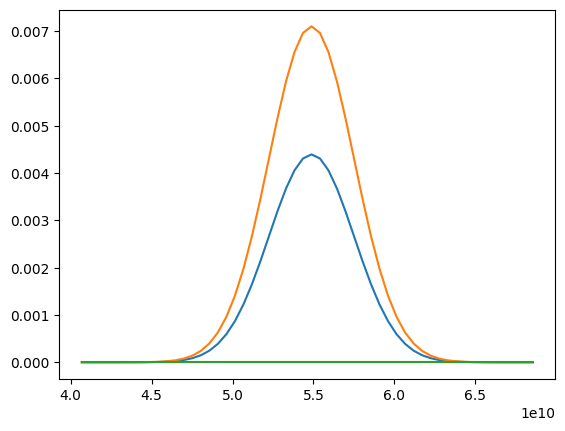

In [59]:
plt.plot(r, p1[:,0])
plt.plot(r, p1[:,1])
plt.plot(r, p1[:,-1])

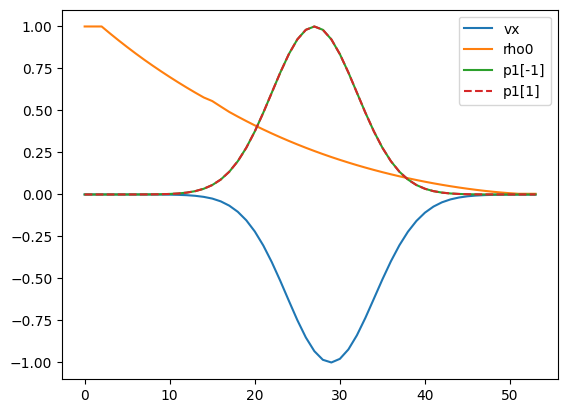

In [56]:
T1, rho1, p1, s1, vx, vz, info = read_fg("../data/test_fix_rk1_upw1_boundary0/snap1.h5")
plt.plot(r, vx[:,0]/(np.abs(vx[:,0]).max()), label='rvx(t$_{n+1}$)')
plt.plot(r, rho0/rho0.max(), label='rho0')
T1, rho1, p1, s1, vx, vz, info = read_fg("../data/test_fix_rk1_upw1_boundary0/snap0.h5")
plt.plot(r, p1[:,-1]/np.abs(p1[:,-1]).max(), label='p1[-1]')
plt.plot(r, p1[:,1]/np.abs(p1[:,1]).max(), label='p1[1]', linestyle="--")
plt.legend()

So we know it's definitely because of p1 but p1 looks to be correct.

In [65]:
info

't: 1.00\nnx: 50\nnz: 50\nnz_ghost: 2\ndx: 70989795.92\ndz: 525324489.80'

In [64]:
#define R_START 0.6 // In units of solar radii
#define R_END 0.97 // In units of solar radii
#define X_SIZE 0.05

((0.97-0.6)/0.05) * 100

740.0

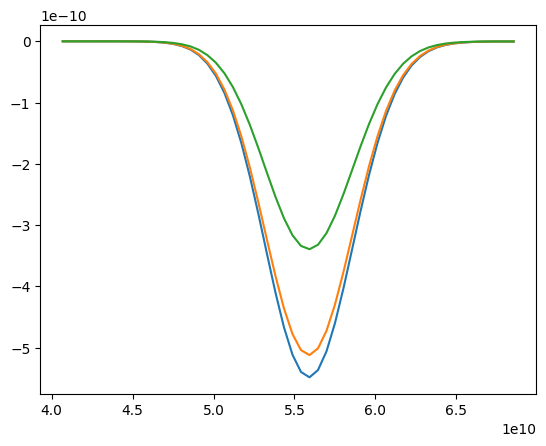

In [60]:
T1, rho1, p1, s1, vx, vz, info = read_fg("../data/test_fix_rk1_upw1_boundary0/snap1.h5")
plt.plot(r, vx[:,0])
plt.plot(r, vx[:,1])
plt.plot(r, vx[:,-1])

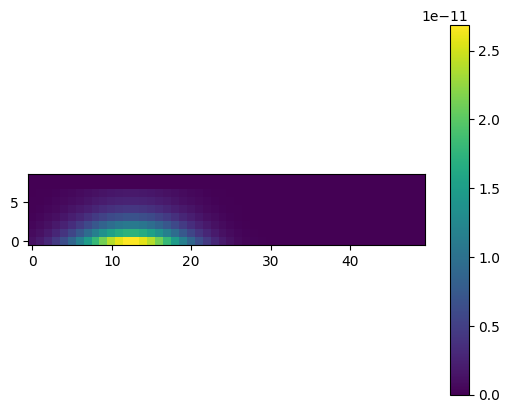

In [36]:
plt.figure()
plt.imshow(vz[-10:-1,:], aspect=1, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
vx[:,2]
plt.figure()
plt.plot(vx[:,0])
plt.plot(vx[:,1])
plt.plot(vx[:,2])
